<a href="https://colab.research.google.com/github/keehyun2/TestPy/blob/master/colab/9-2-v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 순환 신경망으로 IMDB 리뷰 분류하기

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/9-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [67]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)

## IMDB 리뷰 데이터셋

In [68]:
from tensorflow.keras.datasets import imdb

# num_words=200은 가장 자주 등장하는 단어 200개만 사용하도록 제한하여
# 데이터의 크기를 줄이고 모델의 복잡성을 관리합니다.
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=200)

In [69]:
print(train_input.shape, test_input.shape)

(25000,) (25000,)


In [70]:
print(len(train_input[0]))
# 첫번째 리뷰의 단어 개수

218


In [71]:
print(len(train_input[1]))
# 2번째 리뷰의 단어 개수

189


In [72]:
# 정수 인코딩된 토큰 확인
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 4, 173, 36, 2, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 2, 2, 5, 150, 4, 172, 112, 167, 2, 2, 2, 39, 4, 172, 2, 2, 17, 2, 38, 13, 2, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 2, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 2, 12, 8, 2, 8, 106, 5, 4, 2, 2, 16, 2, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 2, 28, 77, 52, 5, 14, 2, 16, 82, 2, 8, 4, 107, 117, 2, 15, 2, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 7, 4, 2, 2, 13, 104, 88, 4, 2, 15, 2, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 2, 22, 21, 134, 2, 26, 2, 5, 144, 30, 2, 18, 51, 36, 28, 2, 92, 25, 104, 4, 2, 65, 16, 38, 2, 88, 12, 16, 2, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


In [73]:
# 20개의 리뷰의 긍정, 부정 여부
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [74]:
from sklearn.model_selection import train_test_split
# 테스트, 검증 분리
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)

In [75]:
import numpy as np

# 각 리뷰의 길이
lengths = np.array([len(x) for x in train_input])

In [76]:
print(np.mean(lengths), np.median(lengths)) # 평균, 중앙값
print(np.max(lengths)) # 최대값
print(np.min(lengths)) # 최소값

239.00925 178.0
1854
11


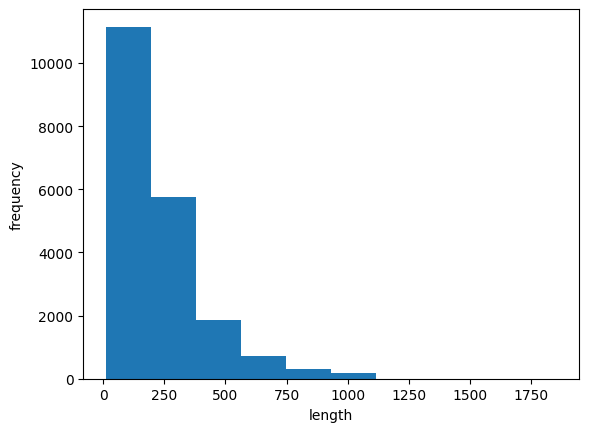

In [77]:
import matplotlib.pyplot as plt

plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

In [78]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 문장의 최대 길이를 100으로 만듬.
train_seq = pad_sequences(train_input, maxlen=100)

In [79]:
print(train_seq.shape)

(20000, 100)


In [80]:
print(train_seq[0])

[ 10   4  20   9   2   2   2   5  45   6   2   2  33   2   8   2 142   2
   5   2  17  73  17   2   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12   2  69   2 142  73   2   6
   2   7   2   2 188   2 103  14  31  10  10   2   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10   2 158]


In [115]:
# 단어-인덱스 딕셔너리 가져오기
word_index = imdb.get_word_index()

# 인덱스-단어 딕셔너리 생성 (인덱스에 3을 더한 값으로)
reverse_word_index = dict([(value + 3, key) for (key, value) in word_index.items()])

# 특수 토큰 매핑 추가
reverse_word_index[0] = "<PAD>"
reverse_word_index[1] = "<START>"
reverse_word_index[2] = "<UNK>"
reverse_word_index[3] = "<UNUSED>"

# 0: 패딩([PAD])
# 1: 문장의 시작([START])
# 2: 사전에 없는 단어([UNK])

for i in range(200):
    print(f"인덱스 {i}: {reverse_word_index.get(i, '?')}")

인덱스 0: <PAD>
인덱스 1: <START>
인덱스 2: <UNK>
인덱스 3: <UNUSED>
인덱스 4: the
인덱스 5: and
인덱스 6: a
인덱스 7: of
인덱스 8: to
인덱스 9: is
인덱스 10: br
인덱스 11: in
인덱스 12: it
인덱스 13: i
인덱스 14: this
인덱스 15: that
인덱스 16: was
인덱스 17: as
인덱스 18: for
인덱스 19: with
인덱스 20: movie
인덱스 21: but
인덱스 22: film
인덱스 23: on
인덱스 24: not
인덱스 25: you
인덱스 26: are
인덱스 27: his
인덱스 28: have
인덱스 29: he
인덱스 30: be
인덱스 31: one
인덱스 32: all
인덱스 33: at
인덱스 34: by
인덱스 35: an
인덱스 36: they
인덱스 37: who
인덱스 38: so
인덱스 39: from
인덱스 40: like
인덱스 41: her
인덱스 42: or
인덱스 43: just
인덱스 44: about
인덱스 45: it's
인덱스 46: out
인덱스 47: has
인덱스 48: if
인덱스 49: some
인덱스 50: there
인덱스 51: what
인덱스 52: good
인덱스 53: more
인덱스 54: when
인덱스 55: very
인덱스 56: up
인덱스 57: no
인덱스 58: time
인덱스 59: she
인덱스 60: even
인덱스 61: my
인덱스 62: would
인덱스 63: which
인덱스 64: only
인덱스 65: story
인덱스 66: really
인덱스 67: see
인덱스 68: their
인덱스 69: had
인덱스 70: can
인덱스 71: were
인덱스 72: me
인덱스 73: well
인덱스 74: than
인덱스 75: we
인덱스 76: much
인덱스 77: been
인덱스 78: bad
인덱스 79: get
인덱스 80: will
인덱스 81: 

In [82]:
# 첫 번째 리뷰 시퀀스(최대 단어 개수 100) 디코딩
decoded_review = " ".join([reverse_word_index.get(i, "?") for i in train_seq[0]])

print(decoded_review)

br the movie is <UNK> <UNK> <UNK> and it's a <UNK> <UNK> at <UNK> to <UNK> something <UNK> and <UNK> as well as <UNK> and <UNK> with very <UNK> <UNK> don't really think this movie made much <UNK> though at the time it got <UNK> though it <UNK> had <UNK> something well <UNK> a <UNK> of <UNK> <UNK> got <UNK> after this one br br <UNK> of <UNK> and <UNK> will most <UNK> be <UNK> by this movie though there are still some <UNK> people out there who will get a <UNK> out of this movie br br <UNK> 10


In [83]:
print(train_input[0])
# 첫 번째 리뷰 시퀀스 디코딩
decoded_review = " ".join([reverse_word_index.get(i, "?") for i in train_input[0]])

print(decoded_review)

[1, 73, 89, 81, 25, 60, 2, 6, 20, 141, 17, 14, 31, 127, 12, 60, 28, 2, 2, 66, 45, 6, 20, 15, 2, 8, 79, 17, 2, 8, 112, 6, 2, 20, 17, 2, 2, 4, 2, 20, 9, 2, 6, 2, 7, 2, 2, 6, 185, 2, 24, 55, 2, 5, 23, 2, 7, 15, 82, 24, 15, 2, 66, 10, 10, 45, 2, 15, 4, 20, 2, 8, 30, 17, 2, 5, 2, 17, 2, 190, 4, 20, 9, 43, 32, 99, 2, 18, 15, 8, 157, 46, 17, 2, 4, 2, 5, 2, 9, 32, 2, 5, 2, 2, 17, 73, 17, 2, 36, 26, 2, 43, 2, 83, 4, 2, 2, 74, 83, 4, 2, 2, 82, 4, 96, 4, 2, 2, 8, 32, 4, 2, 9, 184, 2, 13, 2, 48, 14, 16, 147, 2, 59, 62, 69, 2, 12, 46, 50, 9, 53, 2, 74, 2, 11, 14, 31, 151, 10, 10, 4, 20, 9, 2, 2, 2, 5, 45, 6, 2, 2, 33, 2, 8, 2, 142, 2, 5, 2, 17, 73, 17, 2, 5, 2, 19, 55, 2, 2, 92, 66, 104, 14, 20, 93, 76, 2, 151, 33, 4, 58, 12, 188, 2, 151, 12, 2, 69, 2, 142, 73, 2, 6, 2, 7, 2, 2, 188, 2, 103, 14, 31, 10, 10, 2, 7, 2, 5, 2, 80, 91, 2, 30, 2, 34, 14, 20, 151, 50, 26, 131, 49, 2, 84, 46, 50, 37, 80, 79, 6, 2, 46, 7, 14, 20, 10, 10, 2, 158]
<START> well how do you even <UNK> a movie such as this one doe

In [84]:
print(train_input[0][-10:]) # 정수시퀀스의 끝부분을 중요히 여겨 그대로사용

[6, 2, 46, 7, 14, 20, 10, 10, 2, 158]


In [85]:
print(train_seq[5]) # 정수 시퀀스가 100 이 아래이면 앞부분에 padding (0) 을 추가
# 삭제할때도 앞부분을 주로 지움

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2   2   2 183  10
  10  13  82  79   4   2  36  71   2   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14   2  56 129   2  10  10  21   2  94   2   2   2   2  11 190
  24   2   2   7  94   2   2  10  10  87   2  34  49   2   7   2   2   2
   2   2   2   2  46  48  64  18   4   2]


In [86]:
val_seq = pad_sequences(val_input, maxlen=100)
# 검증데이터도 고정길이로 변경

## 순환 신경망 만들기

In [87]:
from tensorflow import keras

model = keras.Sequential()

model.add(keras.layers.SimpleRNN(8, input_shape=(100, 200)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [88]:
# 정수 시퀀스를 ont-hot encoding , to_categorical 함수를 사용
train_oh = keras.utils.to_categorical(train_seq)

In [89]:
# 각 정수 시퀀스별 200 차원이 추가됨. (200개의 단어가 있어서)
print(train_oh.shape)

(20000, 100, 200)


In [90]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [91]:
# 1번째 정수 시퀀스의 1번째 단어의 200 차원을 sum
print(np.sum(train_oh[0][0]))

1.0


In [92]:
# 검증도
val_oh = keras.utils.to_categorical(val_seq)

In [93]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,681 (6.57 KB)

 Trainable params: 1,681 (6.57 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
!pip install visualkeras
!pip install Pillow


In [95]:
from PIL import Image # 이미지 저장 및 처리를 위해 필요
from IPython.display import Image, display # 이미지를 노트북에 표시하기 위해 필요

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


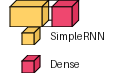

In [96]:
import visualkeras
# 모델 구조 시각화 후 파일로 저장
visualkeras.layered_view(model, legend=True, to_file='model_architecture.png', scale_xy=4, scale_z=4)

# 저장된 이미지 파일을 노트북에 표시
display(Image('model_architecture.png'))

## 순환 신경망 훈련하기

In [97]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.keras',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model.fit(train_oh, train_target, epochs=100, batch_size=64,
                    validation_data=(val_oh, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.4945 - loss: 0.7135 - val_accuracy: 0.4924 - val_loss: 0.7053
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5020 - loss: 0.7038 - val_accuracy: 0.4960 - val_loss: 0.7010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5059 - loss: 0.6993 - val_accuracy: 0.4962 - val_loss: 0.6984
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5124 - loss: 0.6964 - val_accuracy: 0.5038 - val_loss: 0.6962
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5154 - loss: 0.6943 - val_accuracy: 0.5110 - val_loss: 0.6939
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5195 - loss: 0.6925 - val_accuracy: 0.5120 - val_loss: 0.6925
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5228 - loss: 0.6915 - val_accuracy: 0.5162 - val_loss: 0.6917
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5255 - loss: 0.6905 

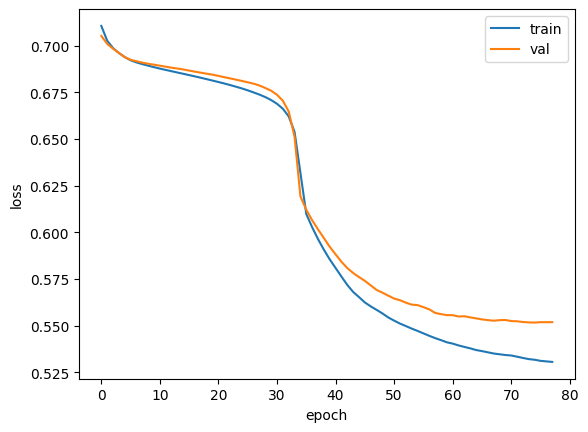

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## 단어 임베딩을 사용하기

In [105]:
# 단어 200 개 그대로 사용 했더니 손실값이 너무 크고, 정확도도 one-hot 인코딩보다 떨어짐.
(train_input, train_target), (test_input, test_target) = imdb.load_data(
    num_words=500)
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42)
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [108]:
model2 = keras.Sequential()

model2.add(keras.layers.Input(shape=(100,)))
model2.add(keras.layers.Embedding(500, 16))
model2.add(keras.layers.SimpleRNN(8))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,209 (32.07 KB)

 Trainable params: 8,209 (32.07 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer='adam', loss='binary_crossentropy',
               metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-embedding-model.keras',
                                                save_best_only=True)

# 최상의 손실값 이후 3 에포크 동안 개선이 없으면 훈련을 중단하겟다.
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3,
                                                  restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64,
                     validation_data=(val_seq, val_target),
                     callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5345 - loss: 0.6886 - val_accuracy: 0.5650 - val_loss: 0.6823
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6095 - loss: 0.6680 - val_accuracy: 0.6050 - val_loss: 0.6578
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6701 - loss: 0.6147 - val_accuracy: 0.6942 - val_loss: 0.6152
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7333 - loss: 0.5412 - val_accuracy: 0.7532 - val_loss: 0.5258
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7753 - loss: 0.4848 - val_accuracy: 0.7624 - val_loss: 0.4932
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7887 - loss: 0.4591 - val_accuracy: 0.7722 - val_loss: 0.4920
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7921 - loss: 0.4575 - val_accuracy: 0.7680 - val_loss: 0.4915
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8054 - loss: 0.4388 - val

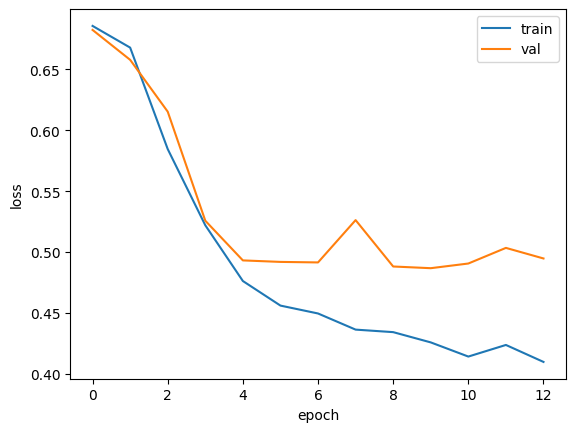

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

/usr/local/lib/python3.12/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


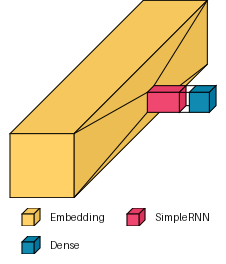

In [111]:
# 이미지 크기를 2배로 키워 저장
visualkeras.layered_view(model2, legend=True, to_file='model_large.png', scale_xy=4, scale_z=4)

# 저장된 이미지 파일을 노트북에 표시
display(Image('model_large.png'))